In [6]:
import os
import pydicom
import rpc3dl

from rpc3dl.files._dicom_util import hierarchy

In [2]:
root = r"D:\testfolder\sample"
filepaths = [os.path.join(root,file) for file in os.listdir(root)]
dcms = [pydicom.dcmread(path) for path in filepaths]

In [11]:
x = hierarchy(dcms,level='modality')

In [12]:
x.keys()

dict_keys(['CT', 'RTDOSE', 'RTPLAN', 'RTSTRUCT'])

In [14]:
series = []
for file in x['CT']:
    series.append(file.SeriesInstanceUID)
series = list(set(series))
print(series)

['1.2.246.352.221.63034041368016423048874865092487846863676518', '1.2.246.352.221.23038576198201713591532161564551901442426364']


In [18]:
plan = x['RTPLAN'][0]

In [22]:
plan.ReferencedStructureSetSequence[0]

(0008, 1150) Referenced SOP Class UID            UI: RT Structure Set Storage
(0008, 1155) Referenced SOP Instance UID         UI: 1.2.246.352.221.33873966504419784554211440933149195819099939

In [23]:
dose = x['RTDOSE'][0]

In [37]:
for ss in x['RTSTRUCT']:
    if ss.SOPInstanceUID == plan.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID:
        break

In [40]:
ss.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID

'1.2.246.352.221.63034041368016423048874865092487846863676518'

In [41]:
def filter_dcms(dcms):
    # check to ensure only one study
    check = hierarchy(dcms,level='study')
    assert len(list(check.keys())) == 1
    
    modsort = hierarchy(dcms,level='modality')
    # first we get our plan file - if only one, we accept
    # if more than one, look for approved status
    if len(modsort['RTPLAN']) == 1:
        plan = modsort['RTPLAN'][0]
    else:
        plan = None
        for planfile in modsort['RTPLAN']:
            if planfile.ApprovalStatus == 'APPROVED':
                plan = planfile
                break
        assert plan is not None
    
    refUID = plan.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID
    ss = None
    for ssfile in modsort['RTSTRUCT']:
        if ssfile.SOPInstanceUID == refUID:
            ss = ssfile
            break
    imgrefUID = ss.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID
    keep_cts = []
    for ct in modsort['CT']:
        if ct.SeriesInstanceUID == imgrefUID:
            keep_cts.append(ct)
    # provision for the sometimes failure to transfer dose files from MIM
    if 'RTDOSE' not in modsort.keys():
        dosefiles = []
    else:
        dosefiles = modsort['RTDOSE']
    
    allfiles = [plan] + [ss] + keep_cts + dosefiles
    return allfiles
            

In [42]:
len(dcms)

408

In [43]:
filtered = filter_files(dcms)
print(len(filtered))

204


In [46]:
destdir = r"D:/testfolder/filtered"
mapper = {
    "CT" : "CT",
    "RTSTRUCT" : "RS",
    "RTDOSE" : "RD",
    "RTPLAN" : "RP"
    }
    
for i,file in enumerate(filtered):
    modality = mapper[str(file.Modality)]
    ptid = str(file.PatientID)
    file.save_as(os.path.join(destdir,"{}_{}_{}.dcm".format(modality,ptid,i)))

C:\Users\johna\anaconda3\envs\phd\lib\site-packages\pydicom\charset.py:486: UserWarning: Found unknown escape sequence in encoded string value - using encoding UTF8
  warnings.warn(msg + f" - using encoding {encodings[0]}")


In [48]:
dose = x['RTDOSE'][0]

In [51]:
ct = filtered[30]

In [53]:
import matplotlib.pyplot as plt

In [56]:
import h5py

In [61]:
with h5py.File(r"D:/testfolder/testfile.h5","r") as f:
    ds = f
    array = ds['base']
    f.close()

In [64]:
def get_dataset():
    f2 = h5py.File(r"D:/testfolder/testfile.h5", 'r')
    return f2['base']
ds = get_dataset()

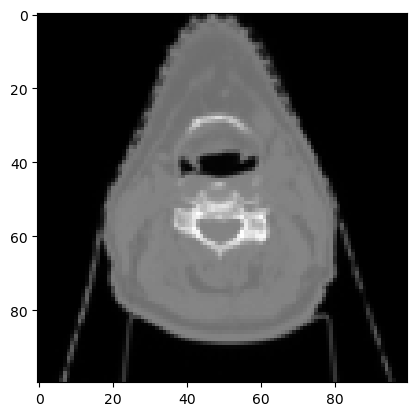

In [75]:
plt.imshow(ds[2,:,:,0],cmap='gray')

In [82]:
ds.keys()

AttributeError: 'Dataset' object has no attribute 'keys'